In this notebook, I will replicate what Tom B did with the takeaway classifier, except that I will replace the classification header with a regression header.

The goals for this notebook is two-fold:

1. Run ULMfit for the regression task using fastai
2. Resample the data to get a balanced dataset

# Data preprocessing


In [ ]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
## Import all the libraries
!pip install unidecode
from unidecode import unidecode
import string
import pandas as pd
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
import string
import string
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 6.9 MB/s 


In [ ]:
train_ds = pd.read_csv('train_smogn.csv')
test_ds = pd.read_csv('test_smogn.csv')

In [ ]:
def rest_name_cleaning(rest_name):
  '''
  This function cleans the restaurant name string
  '''
  rest_name_clean = rest_name.lower()
  rest_name_clean = rest_name_clean.strip()
  ascii_name = unidecode(rest_name_clean)
  ascii_name_fix = ascii_name.replace('`',"'")
  ascii_name_fix = ascii_name_fix.replace('~'," ")
  ascii_name_fix = ascii_name_fix.replace(']'," ")
  ascii_name_fix = ascii_name_fix.replace('['," ")
  ascii_name_fix = ascii_name_fix.replace('\\'," ")
  ascii_name_fix = ascii_name_fix.replace('%'," ")
  ascii_name_fix = ascii_name_fix.replace('*'," ")
  ascii_name_fix = ascii_name_fix.replace('+'," and ")
  ascii_name_fix = ascii_name_fix.replace('&'," and ")
  ascii_name_fix = ascii_name_fix.replace('/'," ")

  return ascii_name_fix

In [ ]:
# test example
# train_ds['ascii_name_fix'] = train_ds.rest_name.apply(rest_name_cleaning)

In [ ]:
# 0-12 if over 12 then 12
def clean_data(data):
  data.loc[data['predict']>12, 'predict'] = 12
  data.loc[data['predict']<0, 'predict'] = 0
  data['ascii_name_fix'] = data.rest_name.apply(rest_name_cleaning)
  return data

In [ ]:
train_ds = clean_data(train_ds)
test_ds = clean_data(test_ds)

In [ ]:
train_ds['is_valid'] = False
test_ds['is_valid'] = True

In [ ]:
justeat_df = pd.concat([train_ds,test_ds], axis=0)

In [ ]:
justeat_df.head()

,Unnamed: 0,index,Restaurant ID,Desserts,Vegetables,Salads,Chips,Water,Milk,Special Offers,...,postcode_district,specialOffers,chips,salads,predict,rating2,ascii_name_fix,is_valid,n_review,review
0,0,21615.0,37196,1,18,4,1,0,0,3,...,G12,3,1,4,8.568073,3,la vita spuntini,False,NaN,NaN
1,1,21158.0,38498,1,18,4,2,0,0,3,...,G12,3,1,4,8.556266,2,la vita spuntini,False,NaN,NaN
2,2,20740.0,35972,2,17,5,2,0,0,3,...,G12,2,2,5,8.546312,3,la vita spuntini,False,NaN,NaN
3,3,25787.0,95230,0,17,2,0,0,0,4,...,G12,4,0,2,8.555663,3,la vita spuntini,False,NaN,NaN
4,4,26378.0,94912,0,16,3,0,0,0,4,...,G12,4,0,2,8.538543,3,la vita spuntini,False,NaN,NaN


In [ ]:
justeat_df.shape, train_ds.shape, test_ds.shape

((62360, 29), (56902, 27), (5458, 28))

In [ ]:
justeat_df.drop(justeat_df.columns[0:2],axis=1,inplace=True)

In [ ]:
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
justeat_df['rest__name_space'] = justeat_df['ascii_name_fix'].apply(split_chars)

In [ ]:
justeat_df = justeat_df[['rest__name_space','predict', 'is_valid']]

In [ ]:
justeat_df.tail()

,rest__name_space,predict,is_valid
5453,s u p e r s h a w a r m a,6.619293,True
5454,b a h a r c a f e,7.049263,True
5455,a m e r i c a n p h i l l i c h e e s e s t e a k,6.134494,True
5456,v i v a p i z z a,5.910214,True
5457,a l i s h a n t a n d o o r i,7.208977,True


In [ ]:
test = 'american philli cheesesteak'
split_chars(test), split_chars(test).split(' ')

('a m e r i c a n   p h i l l i   c h e e s e s t e a k',
 ['a',
  'm',
  'e',
  'r',
  'i',
  'c',
  'a',
  'n',
  '',
  '',
  'p',
  'h',
  'i',
  'l',
  'l',
  'i',
  '',
  '',
  'c',
  'h',
  'e',
  'e',
  's',
  'e',
  's',
  't',
  'e',
  'a',
  'k'])

# train learnner

In [ ]:
import inspect
def print_source(obj):
    for line in inspect.getsource(obj).split("\n"):
        print(line)

print_source(BaseTokenizer)

class BaseTokenizer():
    "Basic tokenizer that just splits on spaces"
    def __init__(self, split_char=' ', **kwargs): self.split_char=split_char
    def __call__(self, items): return (t.split(self.split_char) for t in items)



In [ ]:
# two ways to work around this: add ' ' for each character, or redefine the tokenizer

let's first do it on the word level

In [ ]:
# prepare the data for language model
dls_lm = TextDataLoaders.from_df(justeat_df, is_lm=True, valid_pct=0.1, shuffle_train=True)

In [ ]:
dls_lm.show_batch(max_n=5)

,text,text_
0,xxbos p a p a j o h n ' s - c r a m l i n g t o n xxbos w i c k e d c h i c k e n xxbos s 7 v n ' s xxbos s t a r g r i l l a n d p i z z a h o u s e xxbos c a s a,p a p a j o h n ' s - c r a m l i n g t o n xxbos w i c k e d c h i c k e n xxbos s 7 v n ' s xxbos s t a r g r i l l a n d p i z z a h o u s e xxbos c a s a n
1,e xxbos f l a m e r s s t a r xxbos s u g a r s h a c k xxbos s u g a r s h a c k xxbos e x p r e s s c h i p p y xxbos h e a v e n l y d e s s e r t s - m a n c h,xxbos f l a m e r s s t a r xxbos s u g a r s h a c k xxbos s u g a r s h a c k xxbos e x p r e s s c h i p p y xxbos h e a v e n l y d e s s e r t s - m a n c h e
2,d e s s e r t e x p r e s s xxbos s u g a r s h a c k xxbos l a v i t a s p u n t i n i xxbos s u g a r s h a c k xxbos l a v i t a s p u n t i n i xxbos c o s t a,e s s e r t e x p r e s s xxbos s u g a r s h a c k xxbos l a v i t a s p u n t i n i xxbos s u g a r s h a c k xxbos l a v i t a s p u n t i n i xxbos c o s t a -
3,l e n c a f e xxbos s u g a r s h a c k xxbos m i o i t a l i a n r e s t a u r a n t xxbos l a v i t a s p u n t i n i xxbos b r e a d a n d b u t t e r s a n,e n c a f e xxbos s u g a r s h a c k xxbos m i o i t a l i a n r e s t a u r a n t xxbos l a v i t a s p u n t i n i xxbos b r e a d a n d b u t t e r s a n d
4,r g e r s xxbos s u g a r s h a c k xxbos g o l d e n b o w l xxbos s u g a r s h a c k xxbos s u b w a y ( r ) w e s t w o o d c r o s s xxbos s u g a r s h a c k,g e r s xxbos s u g a r s h a c k xxbos g o l d e n b o w l xxbos s u g a r s h a c k xxbos s u b w a y ( r ) w e s t w o o d c r o s s xxbos s u g a r s h a c k xxbos


In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path='', wd=0.1).to_fp16()

In [ ]:
learn.freeze()

In [ ]:
lr = 1e-1
cycles = 25

In [ ]:
learn.fit_one_cycle(cycles, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.571362,2.848798,0.210178,17.267019,00:58
1,2.689434,2.200784,0.421786,9.032096,00:52
2,2.197866,1.894918,0.462299,6.652000,00:52
3,1.997042,1.772271,0.500148,5.884199,00:52
4,1.889011,1.692256,0.525253,5.431720,00:52
5,1.853880,1.664009,0.531240,5.280438,00:53
6,1.845271,1.640307,0.535472,5.156750,00:52
7,1.811180,1.630448,0.537386,5.106161,00:52
8,1.796463,1.615561,0.542860,5.030711,00:52
9,1.802512,1.609512,0.546954,5.000370,00:53


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(cycles, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.637433,1.472437,0.582110,4.359847,00:56
1,1.488164,1.342599,0.615797,3.828981,00:56
2,1.348803,1.217488,0.651762,3.378689,00:56
3,1.239007,1.133287,0.677655,3.105850,00:56
4,1.154452,1.068019,0.694691,2.909611,00:57
5,1.096087,1.018433,0.709843,2.768854,00:56
6,1.045209,0.984167,0.717833,2.675583,00:56
7,1.012607,0.967644,0.724077,2.631737,00:56
8,0.979910,0.951266,0.729749,2.588986,00:56
9,0.949660,0.939789,0.732718,2.559441,00:56


In [ ]:
TEXT = "BOB"
N_WORDS = 40
N_SENTENCES = 1
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75)
         for _ in range(N_SENTENCES)]

In [ ]:
preds

['XXUNK 0 r e s t a u r a n t s p i c e o f l i f e s u g a r s h a c k s p i c e']

In [ ]:
learn.save_encoder('just_eat_enc_210722')

# Train a regression model

In [ ]:
# loading the data (with both the label and texts)
dls_rn = DataBlock(
    blocks=(TextBlock.from_df('rest__name_space', tok_text_col="rest__name_space"), RegressionBlock),
    get_x=ColReader('rest__name_space'), get_y=ColReader('predict'),
    splitter=ColSplitter())

In [ ]:
dls = dls_rn.dataloaders(justeat_df)

In [ ]:
dls.show_batch(max_n=3)

,text,text_
0,xxbos d o u g h a n d c o w o o d f i r e d p i z z a a n d a r t i s a n p a s t a h a l s t e a d,6.180345058441162
1,"xxbos m r c h i p p y - t r a d i t i o n a l f i s h a n d c h i p s , p i z z a a n d k e b a b s",4.048370361328125
2,xxbos l a r a r e s t a u r a n t - l e b a n e s e a n d m e d i t e r r a n e a n c u i s i n e,6.20351505279541


In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=mae)

In [ ]:
learn.load_encoder('just_eat_enc_210722')

In [ ]:
learn.fit_one_cycle(cycles, 2e-2, cbs=[SaveModelCallback(every_epoch=False, fname='learner_c1'),
                                       EarlyStoppingCallback(monitor='valid_loss', patience=5)])

epoch,train_loss,valid_loss,mae,time
0,5.273640,2.493701,1.260557,01:29
1,5.168935,1.849071,1.044082,01:10
2,4.575679,1.733373,1.020163,01:10
3,5.237940,1.712487,1.008089,01:15
4,5.219352,2.214801,1.142539,01:09
5,5.343300,1.679161,0.985185,01:11
6,4.837605,1.849862,1.068628,01:16
7,5.251155,1.639146,0.978537,01:11
8,5.215017,1.628531,0.979181,01:11
9,5.132993,1.819925,1.058010,01:14


Better model found at epoch 0 with valid_loss value: 2.493701219558716.
Better model found at epoch 1 with valid_loss value: 1.8490707874298096.
Better model found at epoch 2 with valid_loss value: 1.7333734035491943.
Better model found at epoch 3 with valid_loss value: 1.7124871015548706.
Better model found at epoch 5 with valid_loss value: 1.6791614294052124.
Better model found at epoch 7 with valid_loss value: 1.639145851135254.
Better model found at epoch 8 with valid_loss value: 1.6285314559936523.
No improvement since epoch 8: early stopping


In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(cycles, slice(1e-2/(2.6**4),1e-2),
                    cbs=[SaveModelCallback(every_epoch=False,  fname='learner_c2'),
                                       EarlyStoppingCallback(monitor='valid_loss', patience=5)])

epoch,train_loss,valid_loss,mae,time
0,4.081811,1.646856,0.990863,01:15
1,4.395446,1.551679,0.928496,01:19
2,5.178613,1.540373,0.950562,01:14
3,4.862484,1.438420,0.906945,01:12
4,4.651489,1.405441,0.880793,01:10
5,4.739217,1.396223,0.885462,01:11
6,4.961708,1.415473,0.902147,01:11
7,4.534562,1.462004,0.922941,01:11
8,4.575267,1.647493,0.981840,01:11
9,4.243078,1.347472,0.875779,01:10


Better model found at epoch 0 with valid_loss value: 1.6468555927276611.
Better model found at epoch 1 with valid_loss value: 1.5516785383224487.
Better model found at epoch 2 with valid_loss value: 1.5403730869293213.
Better model found at epoch 3 with valid_loss value: 1.4384199380874634.
Better model found at epoch 4 with valid_loss value: 1.4054409265518188.
Better model found at epoch 5 with valid_loss value: 1.396222710609436.
Better model found at epoch 9 with valid_loss value: 1.3474724292755127.
Better model found at epoch 10 with valid_loss value: 1.3192873001098633.
No improvement since epoch 10: early stopping


In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(cycles, slice(5e-3/(2.6**4),5e-3),
                     cbs=[SaveModelCallback(every_epoch=False, fname='learner_c3'),
                                       EarlyStoppingCallback(monitor='valid_loss', patience=5)])


epoch,train_loss,valid_loss,mae,time
0,4.114789,1.305212,0.848170,01:13
1,4.017489,1.341423,0.862134,01:13
2,3.954689,1.326972,0.845968,01:13
3,3.842458,1.350462,0.851032,01:12
4,4.842979,1.432468,0.887877,01:13
5,4.234387,1.511799,0.932408,01:12


Better model found at epoch 0 with valid_loss value: 1.305212140083313.
No improvement since epoch 0: early stopping


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(cycles, slice(1e-3/(2.6**4),1e-3),
                     cbs=[SaveModelCallback(every_epoch=False,fname='fastAI_final'),
                                       EarlyStoppingCallback(monitor='valid_loss', patience=5)])

epoch,train_loss,valid_loss,mae,time
0,4.068131,1.660407,1.001961,01:17
1,4.409080,1.653027,0.991417,01:17
2,4.107059,1.319602,0.853093,01:16
3,4.526675,1.442450,0.905141,01:17
4,3.690846,1.269259,0.826558,01:17
5,4.099947,1.743222,1.011880,01:16
6,3.460001,1.416874,0.879953,01:17
7,3.717012,1.303926,0.829704,01:17
8,4.492030,1.430927,0.866554,01:16
9,3.933269,1.426816,0.865864,01:17


Better model found at epoch 0 with valid_loss value: 1.6604067087173462.
Better model found at epoch 1 with valid_loss value: 1.653026819229126.
Better model found at epoch 2 with valid_loss value: 1.319602131843567.
Better model found at epoch 4 with valid_loss value: 1.2692593336105347.
No improvement since epoch 4: early stopping


### calculate the accuracy

In [ ]:
test_names = ['X\'s fish & chip shop', 'Yuru\'s Pizza & Kebab', 'Yuru\'s Chinese Takeaways','Yuru\'s Sushi Takeaways','Yuru\'s Sushi Restaurant','Yuru\'s Cocktail Bar',
                    'Cambridge Oven','Yo!Sushi','Starbucks','Vanderlyle']

def name_cleaning(name):
  name = rest_name_cleaning(name)
  name = split_chars(name)
  return name

In [ ]:
for name in test_names:
  print(f'{name} -> predicted score {learn.predict(name_cleaning(name))[0]}')

X's fish & chip shop -> predicted score (5.390451908111572,)


Yuru's Pizza & Kebab -> predicted score (5.252383232116699,)


Yuru's Chinese Takeaways -> predicted score (6.014825820922852,)


Yuru's Sushi Takeaways -> predicted score (7.606594562530518,)


Yuru's Sushi Restaurant -> predicted score (8.99078369140625,)


Yuru's Cocktail Bar -> predicted score (7.311500072479248,)


Cambridge Oven -> predicted score (7.615094184875488,)


Yo!Sushi -> predicted score (9.116042137145996,)


Starbucks -> predicted score (6.871275901794434,)


Vanderlyle -> predicted score (7.681985378265381,)


In [ ]:
# evaluate model
preds,targs = learn.get_preds()

In [ ]:
import tensorflow as tf

tf.squeeze(preds).shape, targs.shape

(TensorShape([5458]), torch.Size([5458]))

In [ ]:
# how well does it perform on the test data
from sklearn.metrics import mean_absolute_error
preds_s = tf.squeeze(preds)
mean_absolute_error(preds_s, targs)

0.82655823

In [ ]:
learn.export('fastAI_final_220722.pkl')

# Make predictions with POI data

In [ ]:
# read in test data
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
readRDS = robjects.r['readRDS']
poi = readRDS('food_outlets_os.rds')
poi_df= pandas2ri.rpy2py_dataframe(poi)

In [ ]:
poi_df.head()

,ref_no,name,pointx_class,feature_easting,feature_northing,pos_accuracy,uprn,topo_toid,topo_toid_version,usrn,...,postcode,admin_boundary,telephone_number,url,brand,qualifier_type,qualifier_data,provenance,supply_date,type
1,18857205,Welcome Break (Charnock Richard),1020043,354292.7,415048.2,1,9.881514e-313,osgb1000037990682,8,7401293,...,PR7 5LR,Chorley District,-0.0,www.welcomebreak.co.uk,Welcome Break,Restaurant Type,Roadside,Welcome Break Group Ltd,18687,restaurants
2,20078819,Welcome Break (Hartshead Moor),1020043,416830.0,424112.0,1,-0.000000e+00,osgb1000031997248,5,5302432,...,HD6 4JX,Calderdale District,-0.0,www.welcomebreak.co.uk,Welcome Break,Restaurant Type,Roadside,Welcome Break Group Ltd,18687,restaurants
3,18857213,Welcome Break (Leicester Forest East),1020043,453839.0,302654.0,1,4.941265e-314,osgb5000005161729586,1,2800041,...,LE3 3GB,Blaby District,-0.0,www.welcomebreak.co.uk,Welcome Break,Restaurant Type,Roadside,Welcome Break Group Ltd,18687,restaurants
4,18857223,Welcome Break (Warwick Northbound),1020043,433887.1,257699.7,1,4.944190e-313,osgb1000017044508,11,38303184,...,CV35 0AA,Stratford-on-Avon District,-0.0,www.welcomebreak.co.uk,Welcome Break,Restaurant Type,Roadside,Welcome Break Group Ltd,18687,restaurants
5,18857202,Welcome Break (Abington),1020043,292990.0,625056.0,1,2.391880e-315,osgb1000036194809,14,48306610,...,ML12 6RG,South Lanarkshire,-0.0,www.welcomebreak.co.uk,Welcome Break,Restaurant Type,Roadside,Welcome Break Group Ltd,18687,restaurants


In [ ]:
poi_df['rest_name_space'] = poi_df.name.apply(rest_name_cleaning).apply(split_chars)

In [ ]:
poi_df[['name','rest_name_space']].iloc[1,1]

'w e l c o m e   b r e a k   ( h a r t s h e a d   m o o r )'

In [ ]:
poi_df_for_pred = poi_df['rest_name_space']

In [ ]:
# load the data using the same dataloader
def get_preds_from_series(s: pd.Series, learner: Learner):
    # test_dl creates a new testing DataLoader
    # using the pd.Series of text inputs
    dl_test   = learner.dls.test_dl(s)
    preds     = learner.get_preds(dl=dl_test)

    return preds[0].numpy().flatten()

In [ ]:
poi_df['fastai_pred']= get_preds_from_series(poi_df_for_pred,learn)

In [ ]:
poi_df[['name','rest_name_space','fastai_pred']].sample(n=5)

,name,rest_name_space,fastai_pred
133494,Dixy Chicken,d i x y c h i c k e n,4.564578
116562,Tattu Birmingham,t a t t u b i r m i n g h a m,7.604459
152779,Chicken World,c h i c k e n w o r l d,5.379965
90804,Arabica,a r a b i c a,7.416022
58732,T & 2 Sugars,t a n d 2 s u g a r s,5.075953


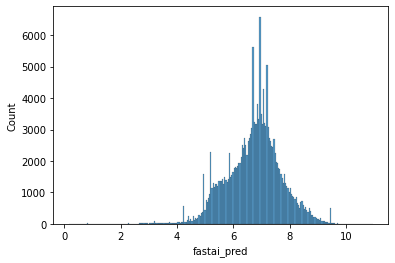

In [ ]:
import seaborn as sns
sns.histplot(poi_df['fastai_pred'])

In [ ]:
poi = poi_df

In [ ]:
poi['pointx_class'].unique()

array(['1020043', '1020013', '1020034', '1020018', '1020019', '1020020'],
      dtype=object)

In [ ]:
poi['type'].head()

1    restaurants
2    restaurants
3    restaurants
4    restaurants
5    restaurants
Name: type, dtype: category
Categories (6, object): ['cafes, snack bars, and tea rooms', 'fast food and takeaway outlets',
                         'fast food delivery services', 'fish and chip shops', 'pubs, bars, and inns',
                         'restaurants']

In [ ]:
poi['type'] = poi['pointx_class'].map({'1020013':'Cafes and tea rooms',
                                       '1020034':'Pubs, bars and inns',
                                       '1020043': 'Restaurants',
                                       '1020018':'Fast food and takeaways',
                                       '1020019':'Fast food and takeaways',
                                       '1020020':'Fast food and takeaways'})

In [ ]:
poi.head()

,ref_no,name,pointx_class,feature_easting,feature_northing,pos_accuracy,uprn,topo_toid,topo_toid_version,usrn,...,telephone_number,url,brand,qualifier_type,qualifier_data,provenance,supply_date,type,rest_name_space,fastai_pred
1,18857205,Welcome Break (Charnock Richard),1020043,354292.7,415048.2,1,9.881514e-313,osgb1000037990682,8,7401293,...,-0.0,www.welcomebreak.co.uk,Welcome Break,Restaurant Type,Roadside,Welcome Break Group Ltd,18687,Restaurants,w e l c o m e b r e a k ( c h a r n o c k r i c h a r d ),6.812756
2,20078819,Welcome Break (Hartshead Moor),1020043,416830.0,424112.0,1,-0.000000e+00,osgb1000031997248,5,5302432,...,-0.0,www.welcomebreak.co.uk,Welcome Break,Restaurant Type,Roadside,Welcome Break Group Ltd,18687,Restaurants,w e l c o m e b r e a k ( h a r t s h e a d m o o r ),6.461704
3,18857213,Welcome Break (Leicester Forest East),1020043,453839.0,302654.0,1,4.941265e-314,osgb5000005161729586,1,2800041,...,-0.0,www.welcomebreak.co.uk,Welcome Break,Restaurant Type,Roadside,Welcome Break Group Ltd,18687,Restaurants,w e l c o m e b r e a k ( l e i c e s t e r f o r e s t e a s t ),6.838035
4,18857223,Welcome Break (Warwick Northbound),1020043,433887.1,257699.7,1,4.944190e-313,osgb1000017044508,11,38303184,...,-0.0,www.welcomebreak.co.uk,Welcome Break,Restaurant Type,Roadside,Welcome Break Group Ltd,18687,Restaurants,w e l c o m e b r e a k ( w a r w i c k n o r t h b o u n d ),6.845292
5,18857202,Welcome Break (Abington),1020043,292990.0,625056.0,1,2.391880e-315,osgb1000036194809,14,48306610,...,-0.0,www.welcomebreak.co.uk,Welcome Break,Restaurant Type,Roadside,Welcome Break Group Ltd,18687,Restaurants,w e l c o m e b r e a k ( a b i n g t o n ),6.553871


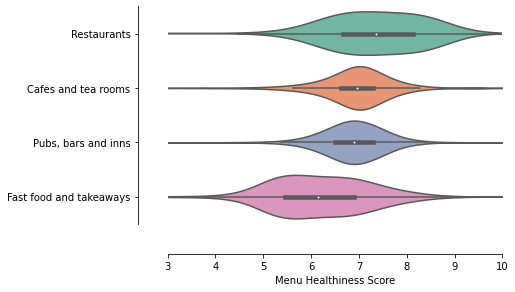

In [ ]:
# Draw a nested boxplot to show bills by day and time
p = sns.violinplot(y="type", x="fastai_pred",scale='width',
            data=poi, palette = "Set2", order=['Restaurants','Cafes and tea rooms',
                                            'Pubs, bars and inns','Fast food and takeaways'],
                    bw=0.4)
#sns.despine(offset=10, trim=True)
p.set_xlim(xmin=3, xmax=10)
p.set(ylabel='', xlabel='Menu Healthiness Score')
# plt.scatter(x='type',y='predicted_score',data= medians_to_add,color='red')
sns.despine(offset=30)
#plt.tight_layout()
# plt.savefig('ViolinPlot_byType.png',dpi=300)
# plt.xticks(rotation=15)
# plt.text('Restaurants',7.0,'3.2', color='red')

In [ ]:
medians_to_add = pd.DataFrame(poi.groupby(['type']).fastai_pred.median()).reset_index()
medians_to_add = medians_to_add.sort_values('fastai_pred',ascending = False)
print(medians_to_add)

                      type  fastai_pred
3              Restaurants     7.364476
0      Cafes and tea rooms     6.951638
2      Pubs, bars and inns     6.891444
1  Fast food and takeaways     6.135065


In [ ]:
poi.to_csv('poi_fastai_220722.csv')